# Randomized Benchmarking

Randomized benchmarking is a technique for quantifying the error of gates on QPU's qubits.

In [1]:
import matplotlib.pyplot as plt
from IPython.display import display

from _logging import setup_logger

logger = setup_logger()

First, let's set up a noisy QPU runner. We modify the compilation options to benchmark specific qubits and prevent any optimization of the Clifford sequences.

In [2]:
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qpu_bench.runner import SimulatedBackendRunner

backend = FakeGuadalupeV2()
qubits_to_benchmark = [8, 9]

comp_opts = {"optimization_level": 0, "initial_layout": qubits_to_benchmark}
noisy_runner = SimulatedBackendRunner(backend, compiler_options=comp_opts)

Now, let's run a standard randomized benchmark.

Error per Clifford is: 0.021490432952342542


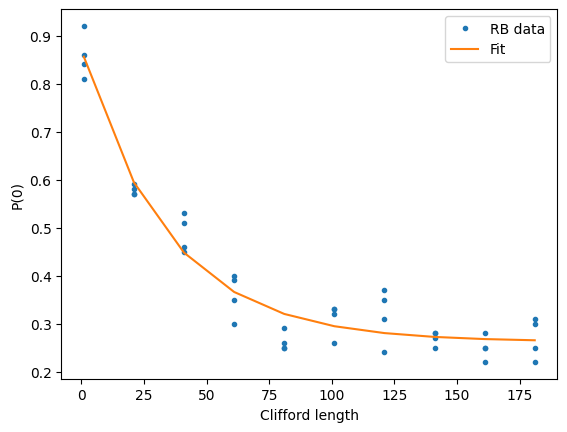

In [3]:
from qpu_bench.rand_bench import run_standard_rb

fig, ax = plt.subplots()
epc = run_standard_rb(noisy_runner, 2, length_range=(1, 200, 20), num_samples=4, ax=ax)

print(f"Error per Clifford is: {epc}")

plt.legend()
plt.show()

Finally, let's run a interleaved randomized benchmark to get the error of a specific native gate (the CX gate).

The error of cx is: 0.010885944181464463


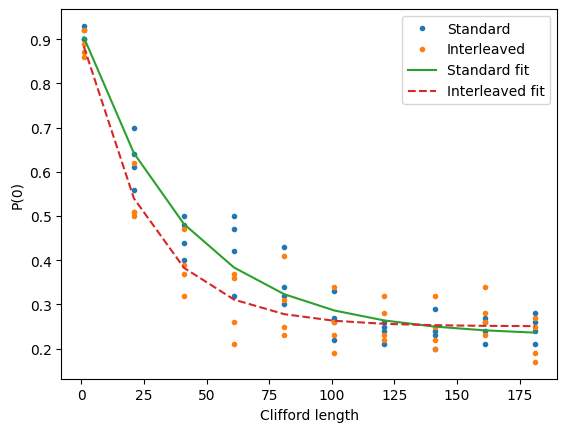

In [4]:

from qiskit.circuit.library import CXGate
from qpu_bench.rand_bench import run_interleaved_rb

gate = CXGate()

fig, ax = plt.subplots()
epc = run_interleaved_rb(noisy_runner, gate, length_range=(1, 200, 20), num_samples=4, ax=ax)

print(f"The error of {gate.name} is: {epc}")

plt.legend()
plt.show()